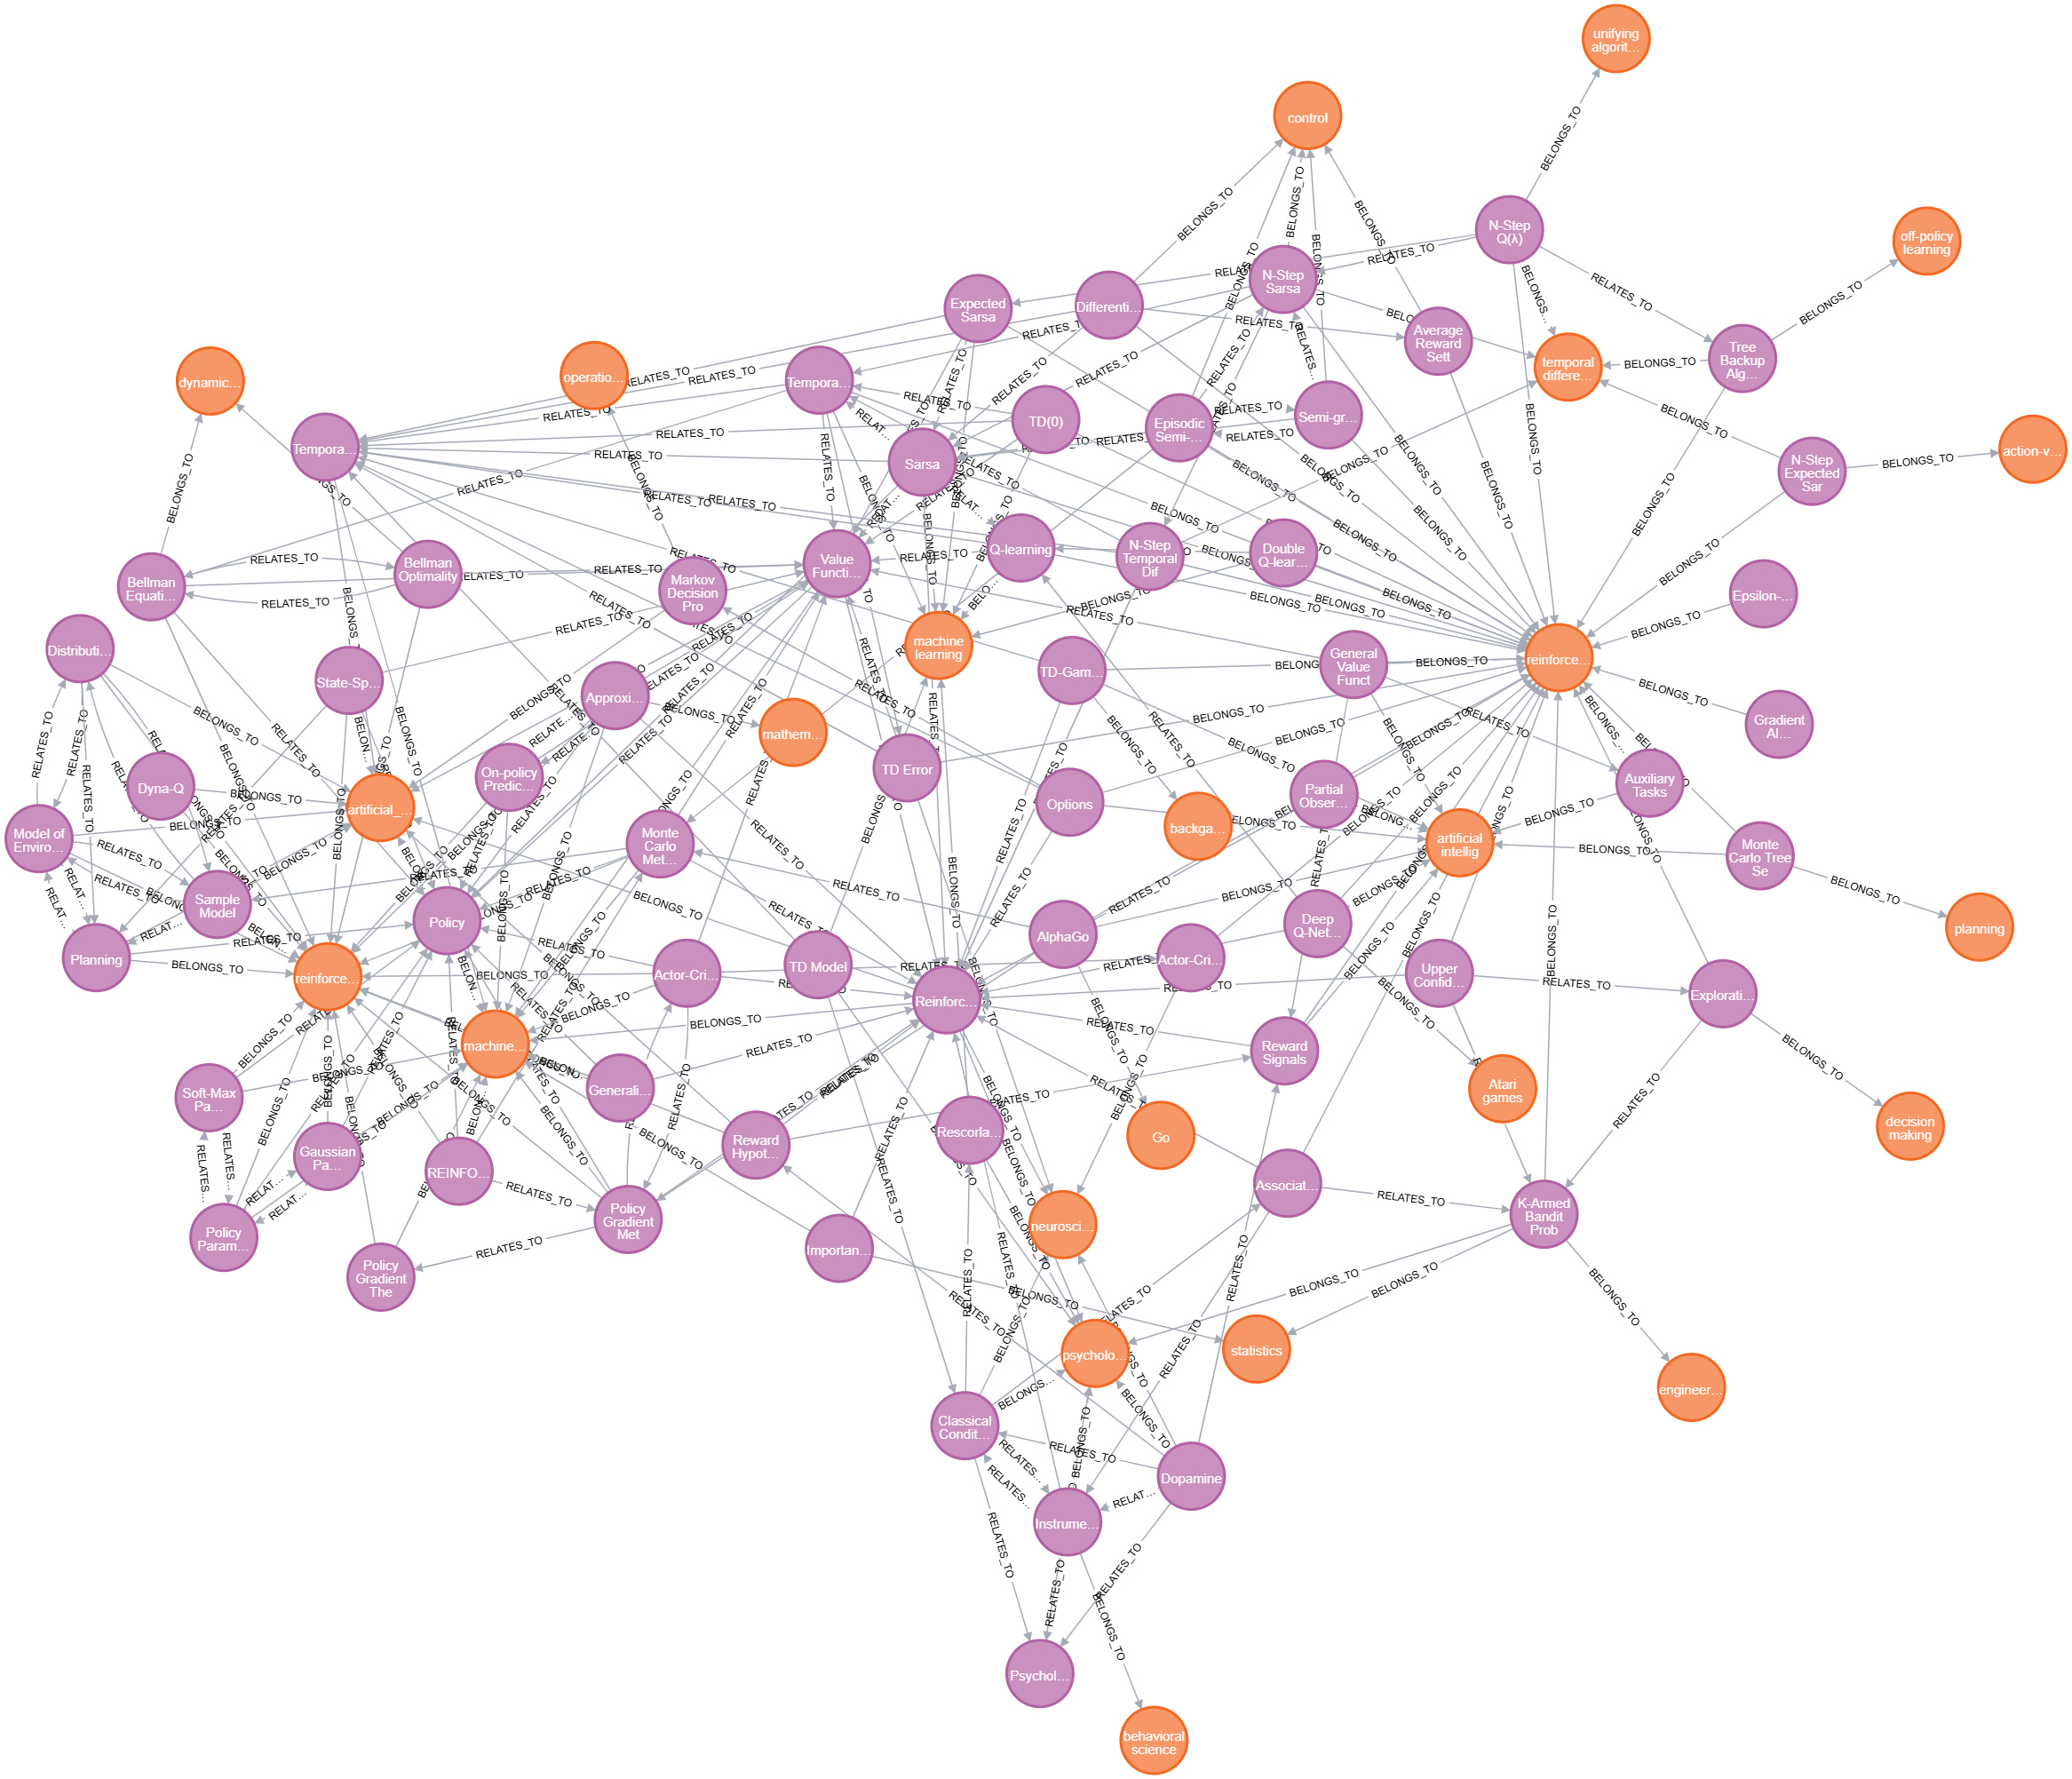

In [ ]:
from neo4j import GraphDatabase
import json

In [8]:
class RLKnowledgeGraph:
    def __init__(self, uri="bolt://localhost:7687", user="your user name here", password="your password here"):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def create_node(self, tx, entity_id, entity_data):
        # Convert properties list to string array
        properties_list = []
        if entity_data.get('properties'):
            for prop in entity_data['properties']:
                prop_str = f"{prop['name']}: {prop['value']}"
                properties_list.append(prop_str)

        # Create node properties
        node_props = {
            'id': entity_id,
            'name': entity_data['name'],
            'type': entity_data['type'],
            'definition': entity_data['definition'],
            'domains': entity_data.get('domains', []),
            'properties': properties_list
        }

        # Create dynamic label from type (clean it for Neo4j label rules)
        type_label = ''.join(c for c in entity_data['type'].title() if c.isalnum())
        
        # Handle domains differently - create a separate Domain label
        if entity_data['type'].lower() == 'domain':
            query = """
            MERGE (n:Domain {id: $id})
            SET n = $node_props
            """
        else:
            # Dynamic query with the type as a label, but don't include Concept label for Domain nodes
            query = f"""
            MERGE (n:Concept:{type_label} {{id: $id}})
            SET n = $node_props
            """
        
        tx.run(query, id=entity_id, node_props=node_props)

    def create_relationships(self, tx, relationships_data):
        try:
            relationships = relationships_data.get('relationships', [])
            
            for rel in relationships:
                # More thorough relationship type cleaning
                rel_type = rel['type'].upper()\
                    .replace(' ', '_')\
                    .replace('(', '')\
                    .replace(')', '')\
                    .replace('-', '_')\
                    .replace('.', '_')\
                    .replace(':', '_')
                
                # Ensure valid Neo4j relationship type
                rel_type = ''.join(c for c in rel_type if c.isalnum() or c == '_')
                
                # Remove any double underscores and strip underscores from ends
                rel_type = '_'.join(filter(None, rel_type.split('_')))
                
                # Modified query to handle both Domain and Concept nodes
                query = f"""
                MATCH (source)
                WHERE source.id = $source
                MATCH (target)
                WHERE target.id = $target
                MERGE (source)-[r:{rel_type}]->(target)
                SET r.source_layer = $source_layer
                SET r.target_layer = $target_layer
                SET r.direction = $direction
                SET r.original_type = $original_type
                """
                
                tx.run(query, 
                    source=rel['source'],
                    target=rel['target'],
                    source_layer=rel['source_layer'],
                    target_layer=rel['target_layer'],
                    direction=rel.get('direction', 'none'),
                    original_type=rel['type']
                )
                
        except Exception as e:
            print(f"Error processing relationship: {e}")
            print(f"Problematic relationship type: {rel['type']}")
            print(f"Cleaned relationship type: {rel_type}")
            raise
        
    def build_graph(self, entities_file, relationships_file):
        # Load data
        with open(entities_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            entities = data['entities']

        with open(relationships_file, 'r', encoding='utf-8') as f:
            relationships_data = json.load(f)

        with self.driver.session() as session:
            # Create nodes
            print("Creating nodes...")
            for entity_id, entity_data in entities.items():
                session.execute_write(self.create_node, entity_id, entity_data)

            # Create relationships
            print("Creating relationships...")
            session.execute_write(self.create_relationships, relationships_data)

            # Add indices
            print("Creating indices...")
            session.execute_write(self.create_indices)

            # Add metadata
            print("Adding metadata...")
            session.execute_write(self.add_metadata)
        
    def add_metadata(self, tx):
        # Add graph metrics for both Domain and Concept nodes
        queries = [
            # Add degree centrality
            """
            MATCH (n)
            WHERE n:Concept OR n:Domain
            SET n.degree = COUNT {(n)--()}
            """,
            # Add in-degree
            """
            MATCH (n)
            WHERE n:Concept OR n:Domain
            SET n.in_degree = COUNT {(n)<--()}
            """,
            # Add out-degree
            """
            MATCH (n)
            WHERE n:Concept OR n:Domain
            SET n.out_degree = COUNT {(n)-->()}
            """
        ]
        for query in queries:
            tx.run(query)

    def create_indices(self, tx):
        queries = [
            "CREATE INDEX concept_type_idx IF NOT EXISTS FOR (n:Concept) ON (n.type)",
            "CREATE INDEX concept_name_idx IF NOT EXISTS FOR (n:Concept) ON (n.name)",
            "CREATE INDEX concept_id_idx IF NOT EXISTS FOR (n:Concept) ON (n.id)",
            "CREATE INDEX domain_id_idx IF NOT EXISTS FOR (n:Domain) ON (n.id)",
            "CREATE INDEX domain_name_idx IF NOT EXISTS FOR (n:Domain) ON (n.name)"
        ]
        for query in queries:
            tx.run(query)

    def close(self):
        self.driver.close()

def main():
    # File paths
    ENTITIES_FILE = r"path to\entities.json"
    RELATIONSHIPS_FILE = r"path to \relationships.json"
    
    # Initialize and build graph
    graph = RLKnowledgeGraph()
    try:
        print("Building knowledge graph...")
        graph.build_graph(ENTITIES_FILE, RELATIONSHIPS_FILE)
        print("Knowledge graph built successfully!")
    except Exception as e:
        print(f"Error building graph: {e}")
        import traceback
        traceback.print_exc()
    finally:
        graph.close()

if __name__ == "__main__":
    main()

Building knowledge graph...
Creating nodes...
Creating relationships...
Creating indices...
Adding metadata...
Knowledge graph built successfully!
